In [118]:
# 12151411 심경수
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read data (each train, test set)
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

# train set, test set의 첫 5개 데이터
# train.head()
# test.head()

# Null값 분석
#print("train data NaN counts\n===================================")
#train.isnull().sum()
#print("test data NaN counts\n===================================")
#test.isnull().sum()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [0]:
# 성별 처리 : 남성(0), 여성(1)
train['Sex'] = train['Sex'].replace(['male', 'female'], [0, 1])
test['Sex'] = test['Sex'].replace(['male', 'female'], [0, 1])

In [0]:
# 특정 속성과 생존여부와의 연관성 분석용 함수
def comp_with_survive(feature) :
    survived = train[train['Survived'] == 1][feature].value_counts()
    dead = train[train['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind = 'bar', stacked = True, figsize = (5, 5))

# 분포 확인
# comp_with_survive('SibSp')
# comp_with_survive('Parch')

# 동반인원 집계
train['Family'] = train['SibSp'] + train['Parch']
test['Family'] = test['SibSp'] + test['Parch']

In [0]:
# train, test 데이터에 호칭 속성 'Title' 추가
combine = [train, test]

for dataset in combine :
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)

# pd.crosstab(train['Sex'], train['Title'])
# pd.crosstab(test['Sex'], test['Title'])

# 분류한 호칭 별 생존자 평균 분석
# train[['Survived', 'Title']].groupby(['Title'], as_index = False).count()

# 호칭 전처리
for dataset in combine :
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev', 'Sir'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Jonkheer'], 'Royal')
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Dona'], 'RoyalFemale')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace( 'Mme', 'Mrs')
    

# 호칭을 매핑한 후 전처리하여 속성으로 사용
train['Title'] = train['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Royal', 'RoyalFemale', 'Rare'], [1, 2, 3, 4, 5, 6, 7])
test['Title']  = test['Title'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Royal', 'RoyalFemale', 'Rare'], [1, 2, 3, 4, 5, 6, 7])

# 만약 있을 Null Value를 대비하여 처리
train['Title'] = train['Title'].fillna(0)
test['Title'] = test['Title'].fillna(0)

# 분류한 호칭 별 생존자 분포 분석
# comp_with_survive('Title')

In [0]:
# Cabin의 첫 글자 (알파벳) 분석
for dataset in combine :
    dataset['Room'] = dataset.Cabin.str.extract('([A-Z])', expand=False)
    dataset['Room'].fillna('a', inplace = True)
    dataset['Room'] = dataset['Room'].replace(['a', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
                                               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], 
                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
                                               15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
    
# comp_with_survive('Room')

In [0]:
# 승선항구 처리 : S(1), Q(2), C(3)
# 결측값은 수가 많은 집단인 S로 편입한다.
train = train.fillna({"Embarked" : 'S'})
train['Embarked'] = train['Embarked'].replace(['S', 'Q', 'C'], [1, 2, 3]).astype('int64')
test['Embarked']  = test['Embarked'].replace(['S', 'Q', 'C'], [1, 2, 3]).astype('int64')

In [0]:
# Age의 결측값 처리 : 평균값으로 대체
train['Age'].fillna(train['Age'].mean(), inplace = True)
test['Age'].fillna(test['Age'].mean(), inplace = True)

# Fare의 결측값 처리 : Pclass의 평균값으로 대체
# print(test[['Pclass', 'Fare']].groupby(['Pclass'], as_index = False).mean())
# print("===========================")
# print(test[test["Fare"].isnull()]["Pclass"])

test['Fare'].fillna(test[test['Pclass'] ==3]['Fare'].mean(), inplace = True)

In [0]:
# 사용하지 않을 속성 제거
x_train = train.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis = 1)
y_train = train['Survived']

x_test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis = 1)

# 정규화(Normalization) 도구 사용
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

x_train_scale = RobustScaler().fit_transform(x_train)
x_test_scale = RobustScaler().fit_transform(x_test)

x_training, x_testing, y_training, y_testing = train_test_split(x_train_scale, y_train, test_size = 0.25, random_state = 66)

In [87]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# evaluate result
LogReg = LogisticRegression().fit(x_training, y_training)
result = (LogReg.predict(x_testing) == y_testing).sum() / len(y_testing)
print("Logistic Regression(Standard)\t:" , result)

Logistic Regression(Standard)	: 0.7757847533632287


In [88]:
# 2. SVM (Support Vector Machine)
from sklearn.svm import SVC

# 선형 SVM에 대해 StandardScaler, RobustScaler 데이터 적용
SVM_Linear = SVC(kernel = 'linear', C = 1)
SVM_Linear.fit(x_training, y_training)

# 비선형 SVM에 대해 StandardScaler, RobustScaler 데이터 적용
SVM_Nonlinear = SVC(kernel = 'rbf', C = 1.0, gamma = 10.0)
SVM_Nonlinear.fit(x_training, y_training)

pred_L = SVM_Linear.predict(x_testing)
pred_NL = SVM_Nonlinear.predict(x_testing)

# evaluate result
print("SVM as Linear\t\t:", (pred_L == y_testing).sum() / len(y_testing))
print("SVM as Non_linear\t:", (pred_NL == y_testing).sum() / len(y_testing))

SVM as Linear		: 0.7757847533632287
SVM as Non_linear	: 0.757847533632287


In [0]:
# 3. DNN
import keras
from keras.layers import Dense, Dropout

# Create DNN model
def DNN_create() :
    DNN = keras.Sequential()        # DNN 모델 생성
    # Input layer
    DNN.add(Dense(16, activation = 'relu', kernel_initializer='he_normal', input_dim = 8))
    # Hidden Layer
    DNN.add(Dense(32, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(48, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(64, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(80, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(64, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(48, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(32, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    DNN.add(Dense(16, activation = 'relu'))
    DNN.add(Dropout(0.2))           # 무작위로 20%의 노드 비활성화
    # Output Layer
    DNN.add(Dense(1, activation = 'sigmoid'))

    # Compile DNN
    DNN.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return DNN

In [110]:
DNN = DNN_create()

log_DNN = DNN.fit(x_training, y_training, epochs = 1000, validation_data = (x_testing, y_testing))

Train on 668 samples, validate on 223 samples
Epoch 1/1000
668/668 [==============================] - 1s 798us/step - loss: 0.6981 - accuracy: 0.5479 - val_loss: 0.6842 - val_accuracy: 0.6547
Epoch 2/1000
668/668 [==============================] - 0s 89us/step - loss: 0.6819 - accuracy: 0.6153 - val_loss: 0.6685 - val_accuracy: 0.6457
Epoch 3/1000
668/668 [==============================] - 0s 84us/step - loss: 0.6725 - accuracy: 0.6123 - val_loss: 0.6491 - val_accuracy: 0.6457
Epoch 4/1000
668/668 [==============================] - 0s 87us/step - loss: 0.6631 - accuracy: 0.6183 - val_loss: 0.6219 - val_accuracy: 0.6547
Epoch 5/1000
668/668 [==============================] - 0s 87us/step - loss: 0.6385 - accuracy: 0.6527 - val_loss: 0.5706 - val_accuracy: 0.7803
Epoch 6/1000
668/668 [==============================] - 0s 89us/step - loss: 0.5902 - accuracy: 0.7066 - val_loss: 0.4885 - val_accuracy: 0.7848
Epoch 7/1000
668/668 [==============================] - 0s 101us/step - loss: 0.547

223/223 [==============================] - 0s 43us/step
0.834080696105957


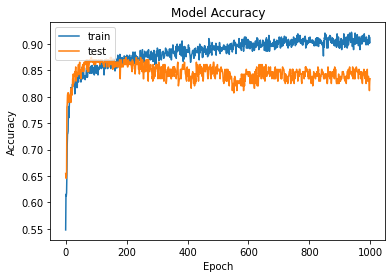

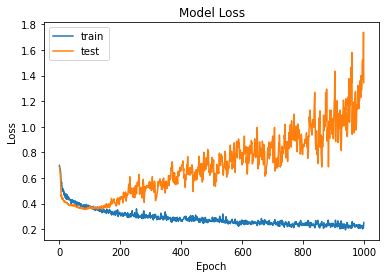

In [113]:
def graph_draw(model) :
    # Accuracy 시각화
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    # Loss 시각화
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

result = DNN.evaluate(x_testing, y_testing)
print(result[1])
graph_draw(log_DNN)     # StandardScaler 적용 시각화

array([[1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
    

In [86]:
# 4. Random Forest model
from sklearn.ensemble import RandomForestClassifier
def RF_create_prepare(x, y) :
    Forest = RandomForestClassifier(n_estimators = 650, min_samples_split = 10, min_samples_leaf = 5)
    Forest.fit(x, y)
    return Forest

RF_Model = RF_create_prepare(x_training, y_training)
RF_test = RF_Model.predict(x_testing)
print("Random Forest score\t: ", (RF_test == y_testing).sum() / len(y_testing))

Random Forest score	:  0.8385650224215246


In [0]:
# Logistic Regression 예측
LogReg = LogisticRegression().fit(x_train_scale, y_train)
Log_predict = LogReg.predict(x_test_scale)

# SVM 예측
SVM_Linear = SVC(kernel = 'linear', C = 1.0)
SVM_Linear.fit(x_train_scale, y_train)
SVM_L_predict = SVM_Linear.predict(x_test_scale)

SVM_Nonlinear = SVC(kernel = 'rbf', C = 1.0, gamma = 10.0)
SVM_Nonlinear.fit(x_train_scale, y_train)
SVM_NL_predict = SVM_Nonlinear.predict(x_test_scale)

# DNN 예측
DNN = DNN_create()
DNN.fit(x_train_scale, y_train, epochs = 1000, batch_size = 128)
DNN_predict = DNN.predict_classes(x_test_scale)

# Random Forest 예측
RF_Model = RF_create_prepare(x_train_scale, y_train)
Forest_predict = RF_Model.predict(x_test_scale)

Epoch 1/1000
891/891 [==============================] - 0s 479us/step - loss: 0.6925 - accuracy: 0.5376
Epoch 2/1000
891/891 [==============================] - 0s 31us/step - loss: 0.6900 - accuracy: 0.5825
Epoch 3/1000
891/891 [==============================] - 0s 33us/step - loss: 0.6821 - accuracy: 0.6263
Epoch 4/1000
891/891 [==============================] - 0s 34us/step - loss: 0.6773 - accuracy: 0.6150
Epoch 5/1000
891/891 [==============================] - 0s 36us/step - loss: 0.6687 - accuracy: 0.6352
Epoch 6/1000
891/891 [==============================] - 0s 36us/step - loss: 0.6612 - accuracy: 0.6285
Epoch 7/1000
891/891 [==============================] - 0s 38us/step - loss: 0.6630 - accuracy: 0.6296
Epoch 8/1000
891/891 [==============================] - 0s 34us/step - loss: 0.6438 - accuracy: 0.6453
Epoch 9/1000
891/891 [==============================] - 0s 32us/step - loss: 0.6243 - accuracy: 0.6745
Epoch 10/1000
891/891 [==============================] - 0s 34us/step - 

In [114]:
Log_predict = pd.DataFrame(Log_predict, columns = ['Survived'])
SVM_L_predict = pd.DataFrame(SVM_L_predict, columns = ['Survived'])
SVM_NL_predict = pd.DataFrame(SVM_NL_predict, columns = ['Survived'])
DNN_predict = pd.DataFrame(DNN_predict, columns = ['Survived'])
Forest_predict = pd.DataFrame(Forest_predict, columns = ['Survived'])

# Make submission file
submission = pd.read_csv("gender_submission.csv")

Log_predict = pd.concat((submission.iloc[:, 0], Log_predict), axis = 1)
Log_predict.to_csv('Logistic_predict.csv', index = False)

SVM_L_predict = pd.concat((submission.iloc[:, 0], SVM_L_predict), axis = 1)
SVM_L_predict.to_csv('SVM_Linear_predict.csv', index = False)

SVM_NL_predict = pd.concat((submission.iloc[:, 0], SVM_NL_predict), axis = 1)
SVM_NL_predict.to_csv('SVM_Nonlinear_predict.csv', index = False)

DNN_predict = pd.concat((submission.iloc[:, 0], DNN_predict), axis = 1)
DNN_predict.to_csv('DNN_predict.csv', index = False)

Forest_predict = pd.concat((submission.iloc[:, 0], Forest_predict), axis = 1)
Forest_predict.to_csv('RandomForest_predict.csv', index = False)

IndexingError: ignored